### Задание.

Примените технологию residual connection для нейросети из лаборатороной работы № 1. Сделайте отображение величины ошибки для тренировочной и валидационной выборки нак графике в процесе вычислений (аналогично примеру выше). Отобразите результат классификации с указанием класса-результата и верного ответа для 10 случайныз картинок тестовой выборки (аналогично примеру выше).

In [5]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [7]:
import torchvision.datasets

# загружаем сразу в трайн и тест
train = torchvision.datasets.FashionMNIST('./', download=True, train=True)
test = torchvision.datasets.FashionMNIST('./', download=True, train=False)

100%|██████████| 26.4M/26.4M [00:07<00:00, 3.43MB/s]


Extracting ./FashionMNIST\raw\train-images-idx3-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 395kB/s]


Extracting ./FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:07<00:00, 599kB/s]


Extracting ./FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting ./FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./FashionMNIST\raw



In [8]:
# формируем датасеты для обучения, тестирования, целевые переменные
X_train = train.train_data
y_train = train.train_labels
X_test = test.test_data
y_test = test.test_labels

C:\ProgramData\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:76: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:66: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:81: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
C:\ProgramData\anaconda3\Lib\site-packages\torchvision\datasets\mnist.py:71: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [9]:
# Названия классов
classes = train.classes
classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [11]:
X_train.shape

torch.Size([60000, 28, 28])

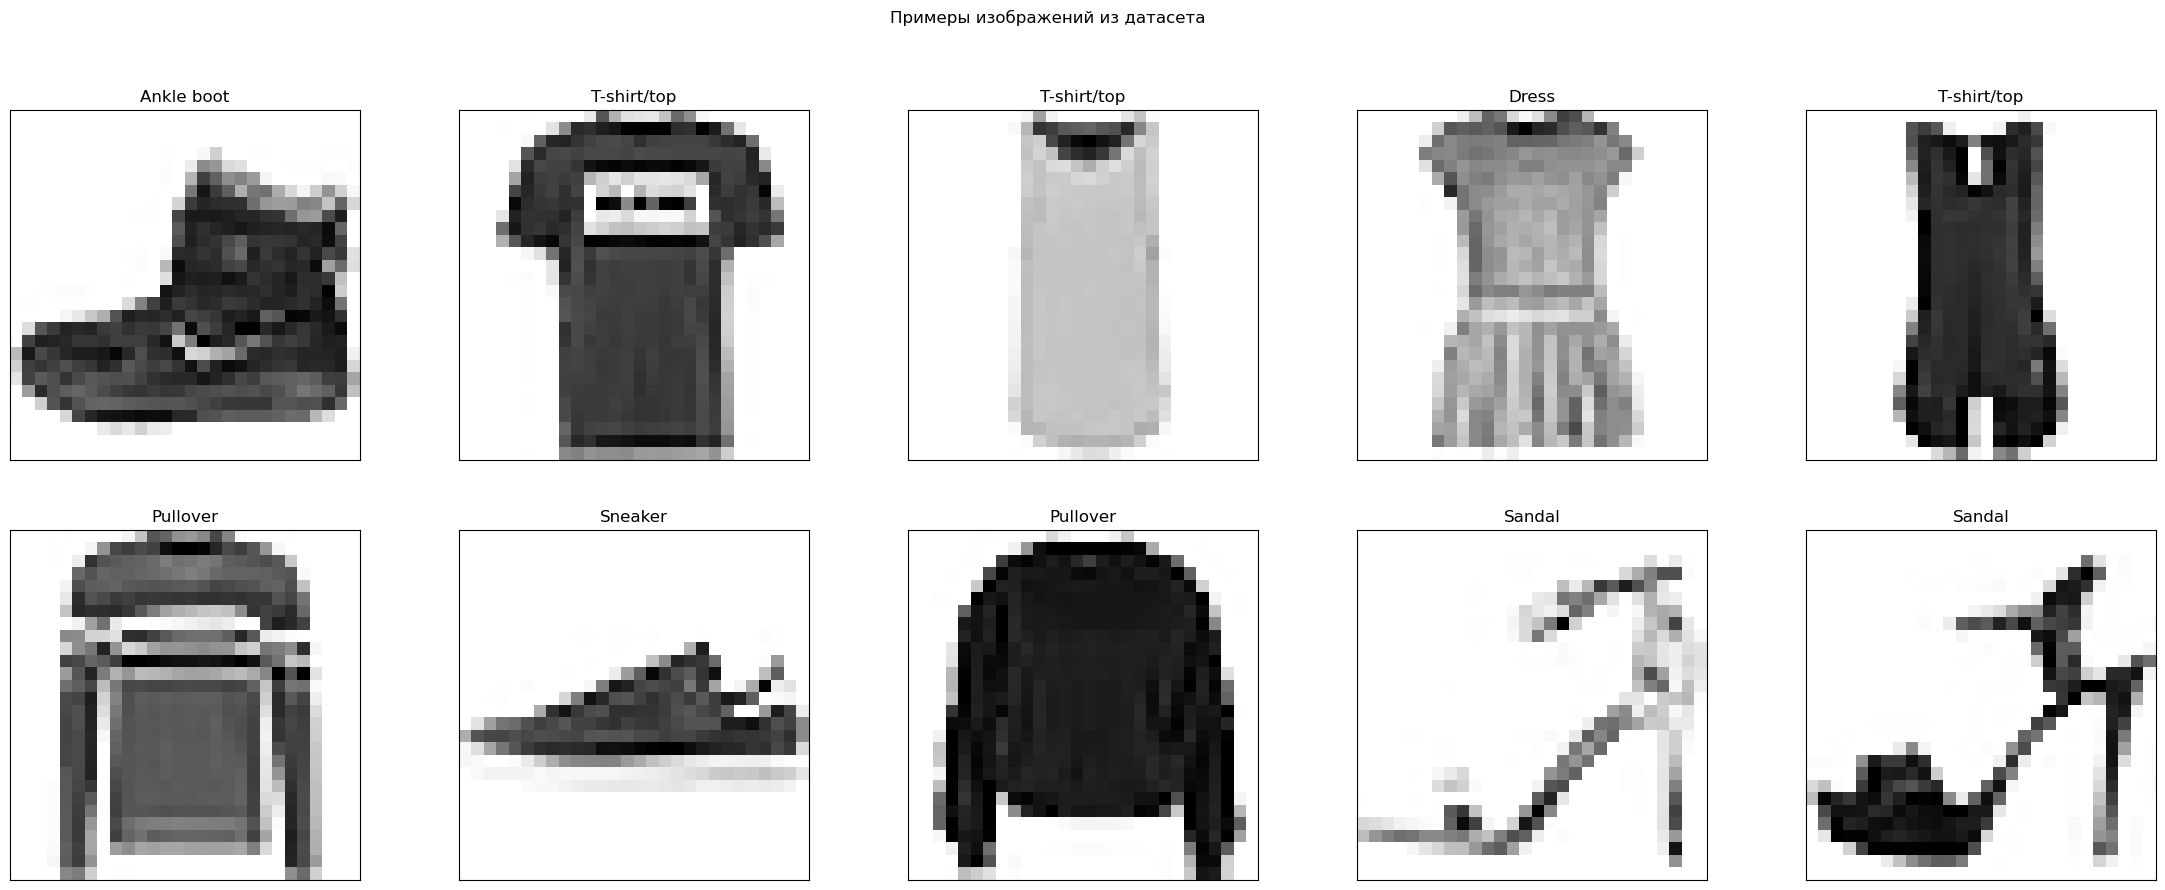

In [12]:
# Посмотрим на то, как выглядят картинки из датасета.

import matplotlib.pyplot as plt
%matplotlib inline

hh = 2
ww = 5

fig, ax = plt.subplots(hh, ww, figsize=(28, 5 * hh))
fig.suptitle("Примеры изображений из датасета")

for i, (x, y) in enumerate(zip(X_train, y_train)):
    if i >= hh * ww:
        break
    plt.subplot(hh, ww, i + 1)
    plt.imshow(x.reshape(28, 28), cmap=plt.cm.Greys)
    plt.xticks([])
    plt.yticks([])
    plt.title(classes[y])
plt.show()

In [13]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [14]:
X_train = torch.tensor(X_train.data) / 255.
X_test = torch.tensor(X_test.data) / 255.

C:\Users\yasur\AppData\Local\Temp\ipykernel_7052\2084532088.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train.data) / 255.
C:\Users\yasur\AppData\Local\Temp\ipykernel_7052\2084532088.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test.data) / 255.


In [15]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [16]:
print(X_train.min(), X_train.max(), X_train.dtype, sep="\n")

tensor(0.)
tensor(1.)
torch.float32


In [17]:
class ResidualBlock(torch.nn.Module):
    # Инициализация блока.
    def __init__(
        self,
        input_c,                              # Число каналов на входе.
        output_c,                             # Число каналов на выходе.
        kernel_size,                          # Размер ядра.
        activation=torch.nn.ReLU,             # Класс функции активации.
    ):
        super().__init__()

        self.activation = activation()

        padding_size = kernel_size // 2
        
        self.conv = torch.nn.Conv2d(
            in_channels=input_c,              # Число каналов на входе.
            out_channels=output_c,            # Число каналов на выходе.
            kernel_size=kernel_size,          # Размер ядра.
            padding=padding_size,             # Размер паддинга (1 элемент добавляется с каждой стороны).
            padding_mode="zeros",             # Указываем, что в паддинге проставляем нули вдоль границ входного тензора.
            stride=1,                         # Stride - 1 (смотрим на каждую позицию).
            dilation=1,                       # Dilation - 1 (ядро прикладывается к фрагменту изображения без пропусков).
        )

        if input_c != output_c:
            self.correct_channels = torch.nn.Conv2d(
                in_channels=input_c,          # Число каналов на входе.
                out_channels=output_c,        # Число каналов на выходе.
                kernel_size=1,                # Размер ядра.
                padding=0,                    # Размер паддинга (1 элемент добавляется с каждой стороны).
                padding_mode="zeros",         # Указываем, что в паддинге проставляем нули вдоль границ входного тензора.
                stride=1,                     # Stride - 1 (смотрим на каждую позицию).
                dilation=1,
        )
        else:
            self.correct_channels = torch.nn.Identity()

    def forward(self, x):
        return self.activation(self.conv(x)) + self.correct_channels(x)

In [18]:
class LeNet5(torch.nn.Module):
    # конструктор. Определям вообще какие слои у нас будут
    def __init__(self):
        super(LeNet5, self).__init__()

        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.ReLU()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()

        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()

        self.fc3   = torch.nn.Linear(84, 10)

    # наша самая главная функция. Определяем, что и в каком порядке будет вызываться
    def forward(self, x):

        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)

        return x

# переменная - наша нейронка
lenet5 = LeNet5()

In [19]:
device = torch.device('cpu')

lenet5 = lenet5.to(device)

In [20]:
# в качестве функции потерь будем использовать CrossEntropyLoss()
loss_fn = torch.nn.CrossEntropyLoss()

# в качестве оптимайзера, который будет вычислять градиенты и минимизировать функцию потерь, будем использовать Adam (Адаптивная оценка момента)
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

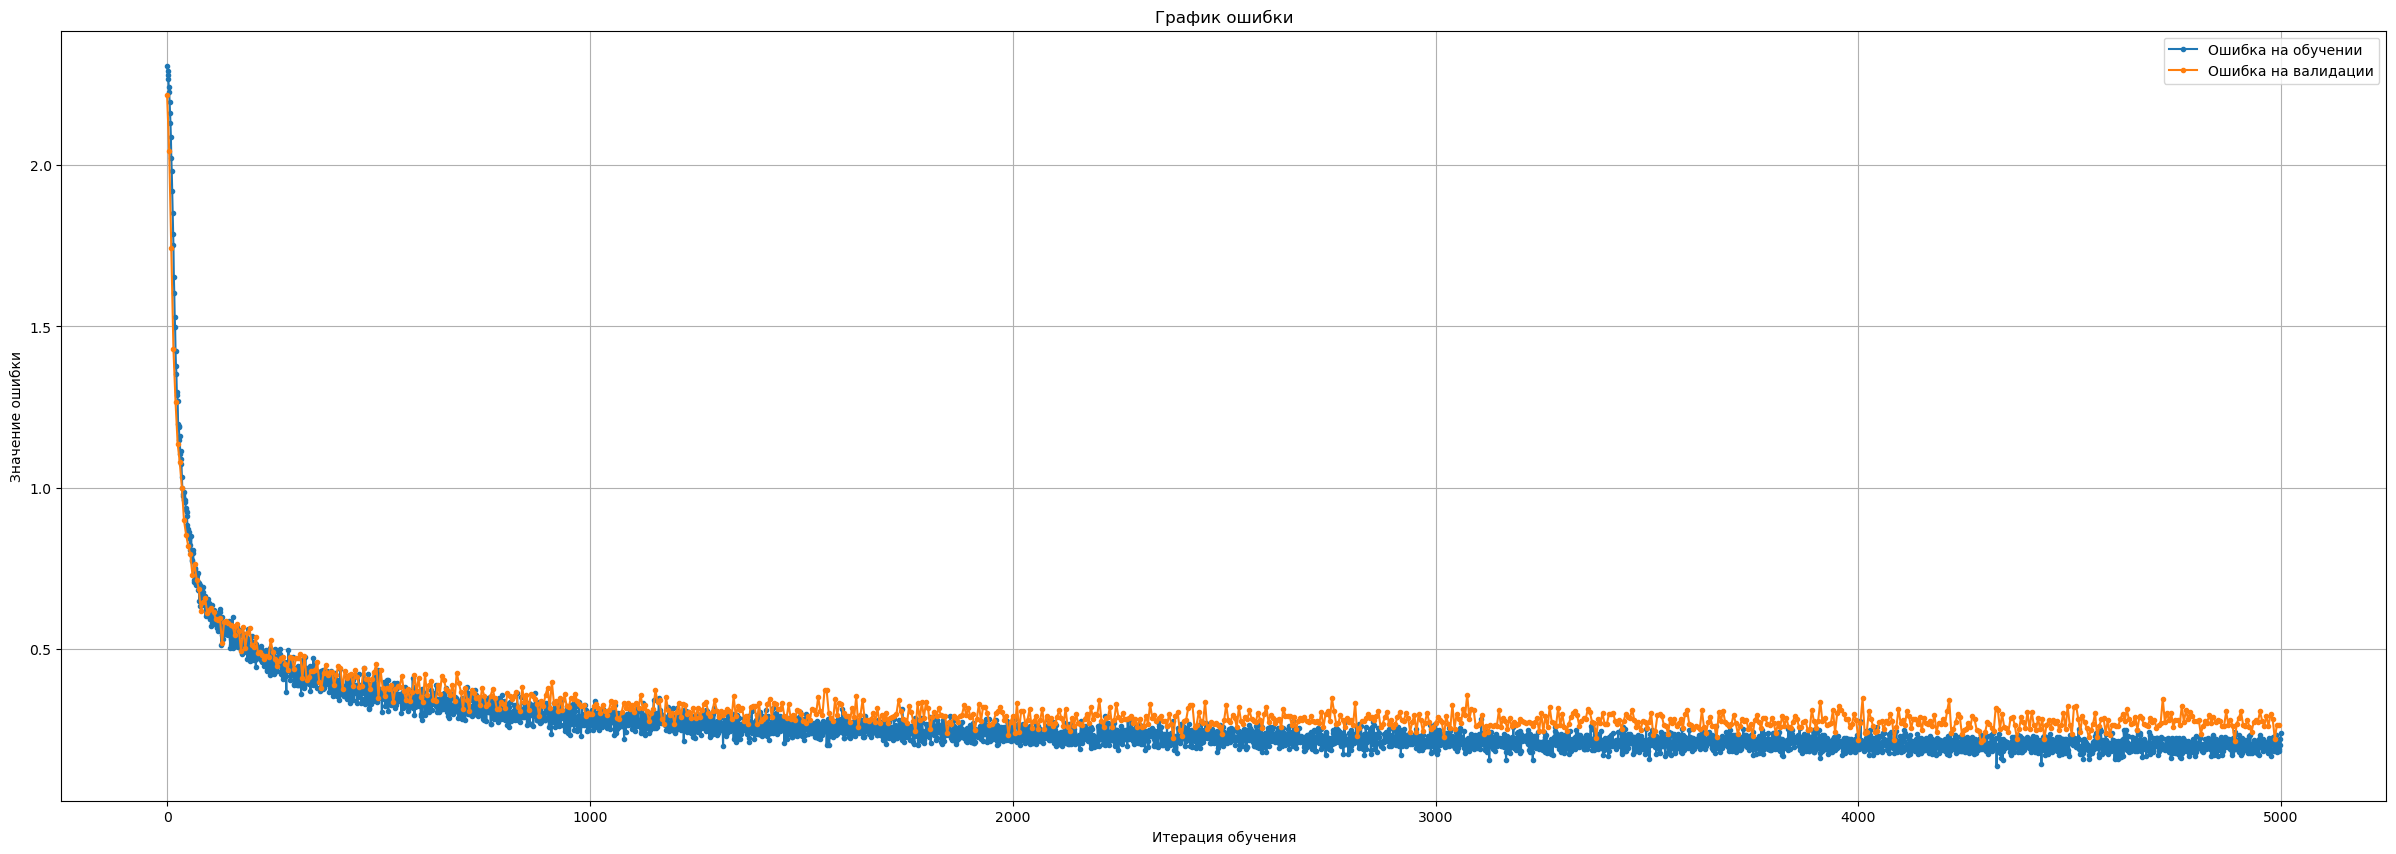

In [21]:
from IPython.display import clear_output

losses = {"train": [], "val": []}

# Шедулер (scheduler) отвечает за изменение величины шага градиентного спуска, который
#  в данном случае мы будем постепенно уменьшать с течением времени.
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

num_epochs = 5000
batch_size = 1000
val_every = 5

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(1, num_epochs + 1):
    #print('epoch', epoch)
    optimizer.zero_grad()

    batch_pos = torch.randint(high=X_train.shape[0], size=[batch_size])

    pred = lenet5.forward(X_train[batch_pos].to(device))  # Также переносим тензоры на устойство.
    loss = loss_fn(pred, y_train[batch_pos].to(device))

    loss.backward()
    optimizer.step()

    losses["train"].append(loss.item())

    # Каждые val_every итераций считаем значение loss на валидационной выборке.
    if epoch % val_every == 0:
        with torch.no_grad ():
            val_batch_pos = torch.randint(high=X_test.shape[0], size=[batch_size])
            val_pred = lenet5(X_test[val_batch_pos].to(device))
            val_loss = loss_fn(val_pred, y_test[val_batch_pos].to(device))
            losses["val"].append(val_loss.item())

    # Каждые 1000 итераций уменьшаем шаг градиентного спуска.
    if epoch % 1000 == 0:
        scheduler.step()

    # Каждые 100 итераций рисуем графики loss.
    if epoch % 100 == 0:
        print('epoch', epoch)
        clear_output(True)
        fig, ax = plt.subplots(figsize=(30, 10))
        plt.title("График ошибки")
        plt.plot(losses["train"], ".-", label="Ошибка на обучении")
        plt.plot(torch.arange(0, epoch, val_every), losses["val"], ".-", label="Ошибка на валидации")
        plt.xlabel("Итерация обучения")
        plt.ylabel("Значение ошибки")
        plt.legend()
        plt.grid()
        plt.show()

In [25]:
def show_results(model, h=2, w=5):
    with torch.no_grad():
        batch_indices = torch.randint(0, X_test.shape[0], (h * w,))
        batch_probs = model(X_test[batch_indices].to(device)).exp()

        fig, ax = plt.subplots(h, w, figsize=(30, 9 * h))
        for i in range(h * w):
            plt.subplot(h, w, i+1)
            plt.imshow(X_test[batch_indices[i]].cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys)
            title = f'Реальный класс: {classes[y_test[batch_indices[i]]]}\n\nПредсказания:'
            y_pred = torch.argmax(batch_probs[i])
            for j, prob in enumerate(batch_probs[i][:27]):
                title += '\n{}{}{: <10} : {}'.format(
                    "" if j!= y_pred else "> ",
                    "" if j!= y_test[batch_indices[i]] else "+ ",
                    classes[j],
                    round(prob.item(), 4),
                )

            plt.title(title)
            plt.xticks([])
            plt.yticks([])
        plt.show()

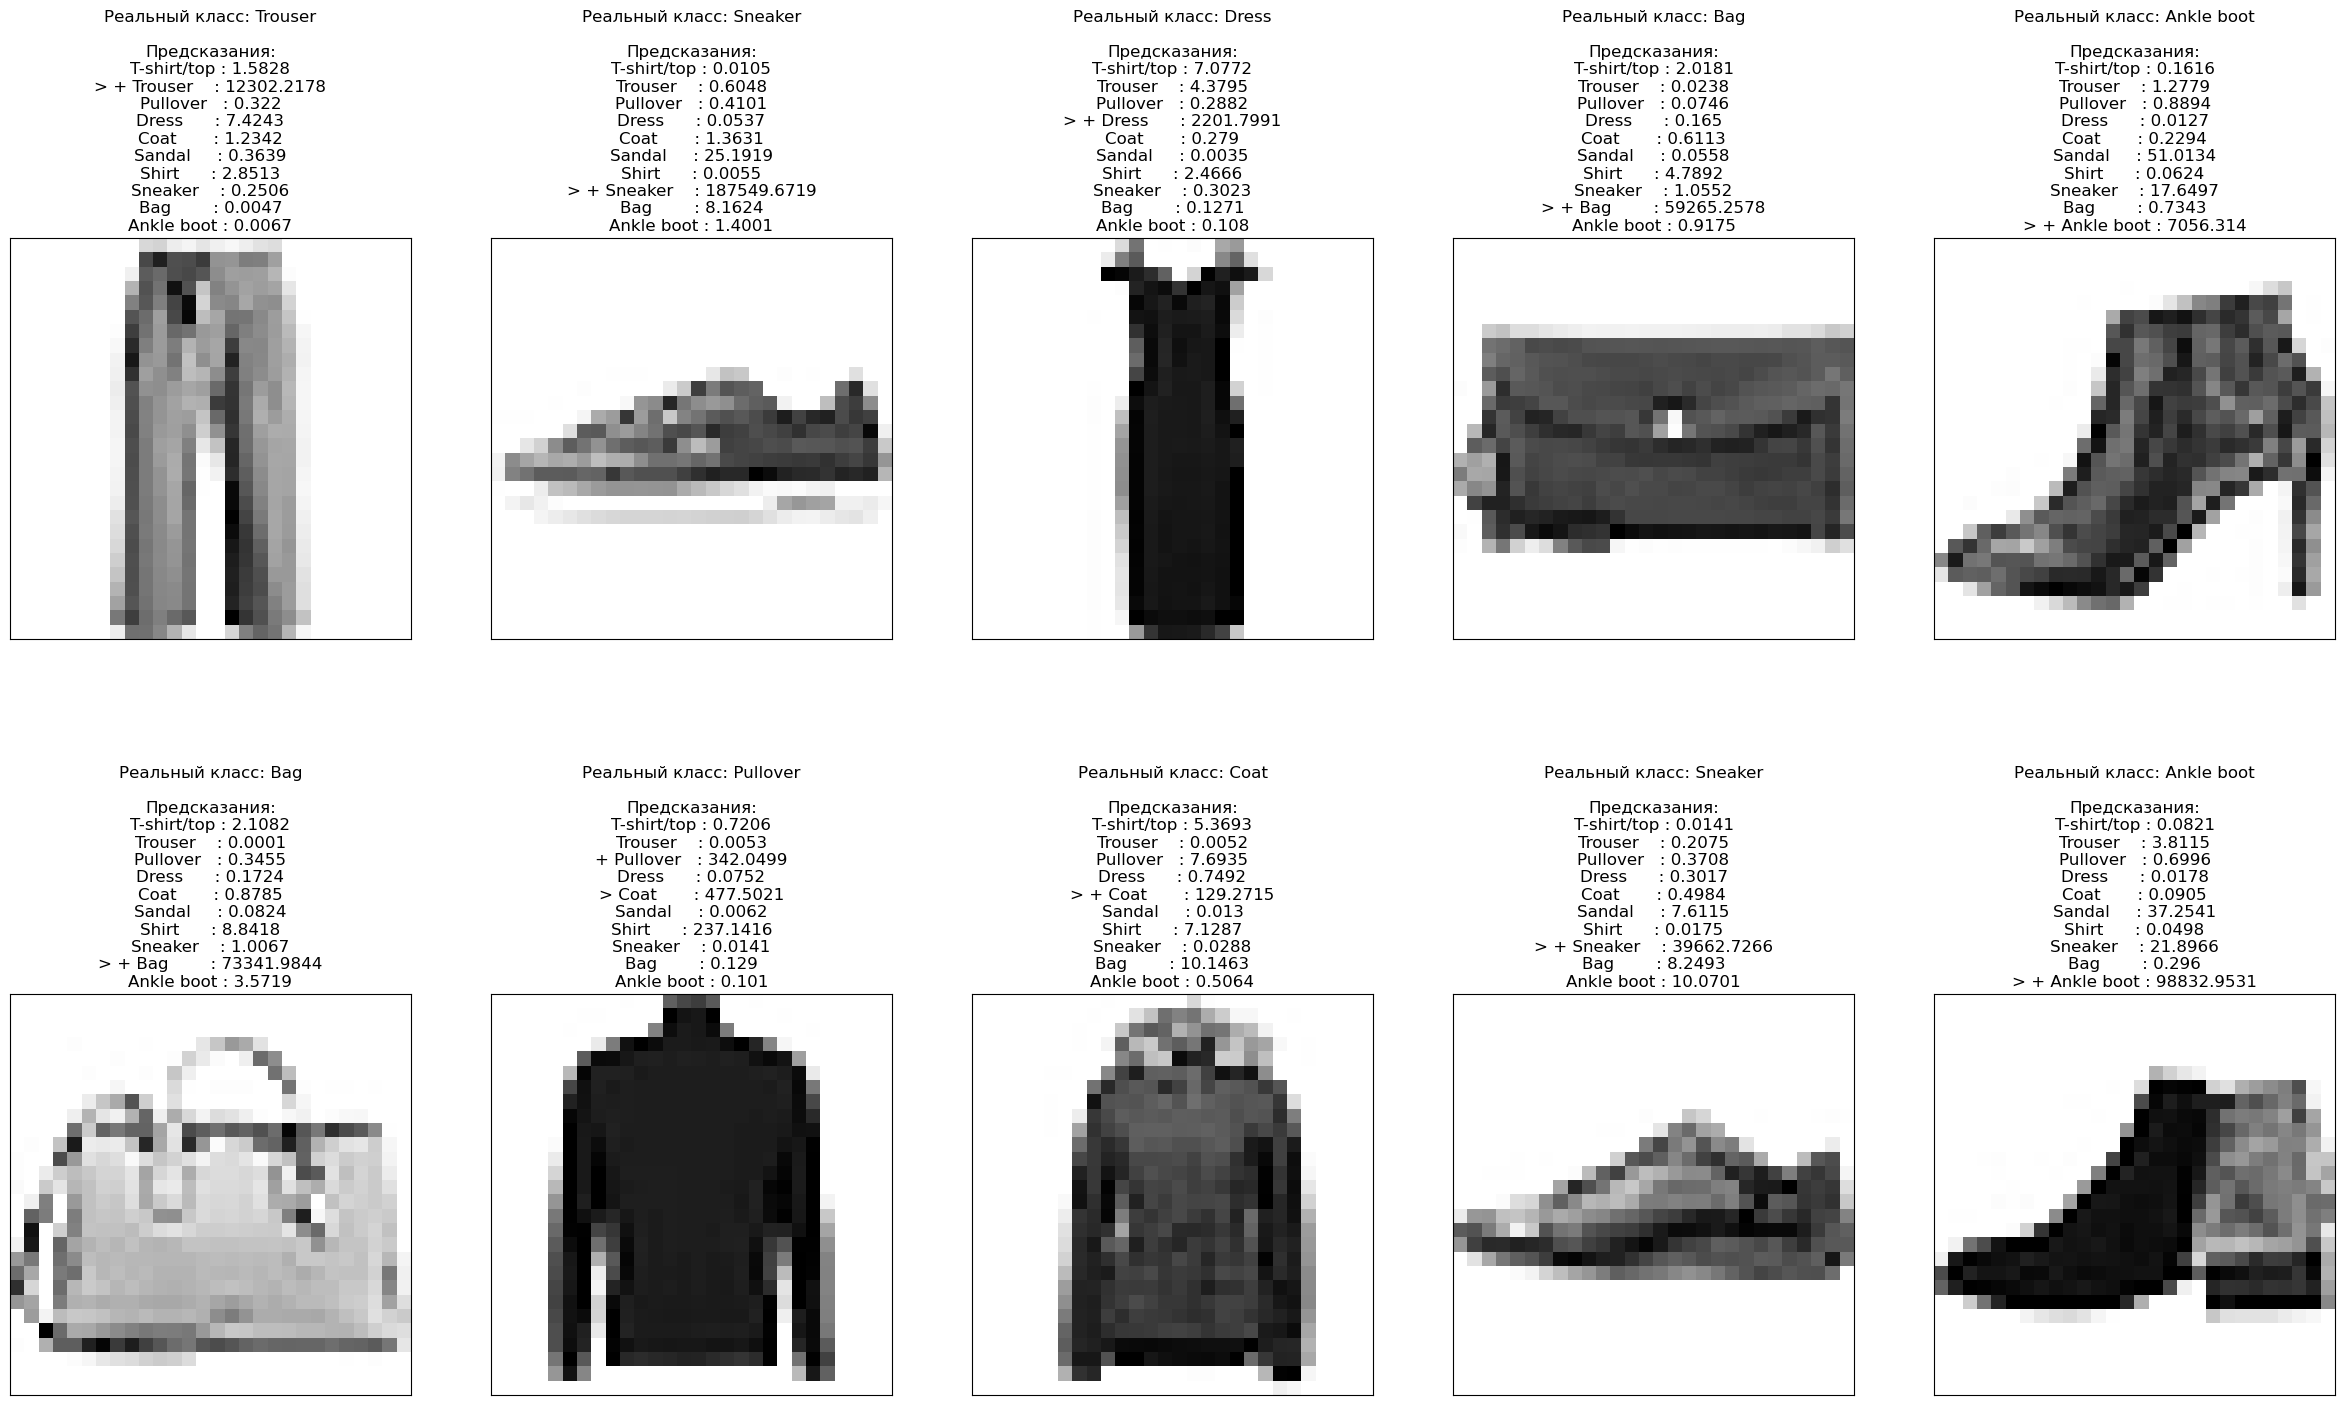

In [26]:
show_results(lenet5)